# Generative Adversarial Network
- 2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle

#create the folder images/gan if it does not exist
import os
if not os.path.exists('images/gan'):
    os.makedirs('images/gan')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu') #for debugging

In [2]:
matplotlib.style.use('ggplot')
torch.manual_seed(1)

# learning parameters
batch_size = 256
epochs = 150 # 800 but maybe even more is better, 20 ~ 5 min
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the netD

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)), #this is very important
])

to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [3]:
class netG(nn.Module):
    def __init__(self, nz):
        super(netG, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28) #unflatten the image

class netD(nn.Module):
    def __init__(self, out_dim):
        super(netD, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, out_dim),
            #nn.Sigmoid(), # sigmoid will be applied before loss only in the last output
        )

    def forward(self, x):
        x = x.view(-1, 784) #flatten the image
        return self.main(x)

In [4]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the netG
def save_generator_image(image_batch, path):
    save_image(image_batch, path)

# function to train the netD network
def train_discriminator(optimizer, real_image_batch, fake_image_batch, loss_fn, netD, targets, class_loss_fn=nn.CrossEntropyLoss()):
    b_size = real_image_batch.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    # print(f"real_label shape: {real_label.shape}")
    # print(f"targets shape: {targets.shape}")
    optimizer.zero_grad()

    output_real = netD(real_image_batch)
    #divide the output in target and true/fake label
    output_real_target = output_real[:, :10]
    output_real_label = output_real[:, 10:]
    # apply sigmopid 
    output_real_label = torch.sigmoid(output_real_label)

    # assert output_real_target.shape == targets.shape , f"output_real_target shape: {output_real_target.shape} and targets shape: {targets.shape}"
    # assert output_real_label.shape == real_label.shape, f"output_real_label shape: {output_real_label.shape} and real_label shape: {real_label.shape}"

    loss_real = loss_fn(output_real_label, real_label) # BCE loss
    class_loss_real = class_loss_fn(output_real_target, targets) # cross entropy loss

    output_fake = netD(fake_image_batch)
    output_fake_target = output_fake[:, :10]
    output_fake_label = output_fake[:, 10:]
    output_fake_label = torch.sigmoid(output_fake_label)

    # assert output_fake_target.shape == targets.shape, f"output_fake_target shape: {output_fake_target.shape} and targets shape: {targets.shape}"
    # assert output_fake_label.shape == fake_label.shape, f"output_fake_label shape: {output_fake_label.shape} and fake_label shape: {fake_label.shape}"

    loss_fake = loss_fn(output_fake_label, fake_label) # BCE loss
    class_loss_fake = class_loss_fn(output_fake_target, targets) # cross entropy loss

    loss_real.backward(retain_graph=True)
    loss_fake.backward(retain_graph=True)
    class_loss_real.backward()
    class_loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake

# function to train the netG network
def train_generator(optimizer, fake_image_batch, loss_fn, netD, targets, class_loss_fn=nn.CrossEntropyLoss()):
    b_size = fake_image_batch.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = netD(fake_image_batch)

    output_target = output[:, :10]  #class
    output_label = output[:, 10:]   #real/fake
    output_label = torch.sigmoid(output_label)

    loss = loss_fn(output_label, real_label)
    class_loss = class_loss_fn(output_target, targets)

    loss.backward(retain_graph=True)
    class_loss.backward()
    optimizer.step()

    return loss    

In [5]:
netG = netG(10+nz).to(device) # 10 is the number of classes, first
netD = netD(10+1).to(device) # 10 is the number of classes, first

print(netG)
print(netD)

# optimizers
optim_g = optim.Adam(netG.parameters(), lr=0.0002)
optim_d = optim.Adam(netD.parameters(), lr=0.0002)

# loss function
loss_fn = nn.BCELoss()

losses_g = [] # to store netG loss after each epoch
losses_d = [] # to store netD loss after each epoch
images = [] # to store images generatd by the netG

netG(
  (main): Sequential(
    (0): Linear(in_features=138, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
netD(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=11, bias=True)
  )
)


In [6]:
## Training
load_good_GAN = False
# good_GAN_G_path = 'good_models/netG_epoch_800.pth'
# good_GAN_D_path = 'good_models/netD_epoch_800.pth'

if not load_good_GAN: # RETRAIN THE GAN

    # create the noise vector
    noise = create_noise(sample_size, nz)
    #create an ordered list of targets
    targ = torch.zeros(sample_size, 10)
    for i in range(sample_size):
        targ[i, i%10] = 1
    targ = targ.to(device)
    gen_input = torch.cat((targ, noise), 1) # concatenate noise and targets
    # print(f"gen_input: {gen_input}")

    netG.train()
    netD.train()

    for epoch in tqdm(range(epochs)):
        # print(f"Epoch {epoch} of {epochs}")

        # train the discriminator more in the later epochs
        if epoch > 60:
            k = 2
            if epoch > 80:
                k = 4
                if epoch > 100:
                    k = 6


        loss_g = 0.0
        loss_d = 0.0
        for bi, data in enumerate(train_dataloader):
            image_batch, labels = data
            #one-hot-encode labels
            targets = torch.eye(10)[labels]
            image_batch, targets = image_batch.to(device), targets.to(device)
            b_size = len(image_batch)
            # run the netD for k number of steps
            for step in range(k):
                noi = create_noise(b_size, nz)
                G_input_vector = torch.cat((targets, noi), 1) # concatenate the labels and noise, labels first
                # print(input.shape)
                fake_image_batch = netG(G_input_vector).detach()
                real_image_batch = image_batch
                # train the netD network
                loss_d += train_discriminator(optim_d, real_image_batch, fake_image_batch, loss_fn, netD, targets)
            
            noi = create_noise(b_size, nz)
            G_input_vector = torch.cat((targets, noi), 1) # concatenate the labels and noise, labels first
            fake_image_batch = netG(G_input_vector)
            # train the netG network
            loss_g += train_generator(optim_g, fake_image_batch, loss_fn, netD, targets)

        # create the final fake image_batch for the epoch
        generated_img = netG(gen_input).cpu().detach()
        # make the images as grid
        generated_img = make_grid(generated_img)
        # save the generated torch tensor models to disk
        save_generator_image(generated_img, f"data/training/ACgen_img{epoch}.png")
        images.append(generated_img)
        epoch_loss_g = loss_g / bi # total netG loss for the epoch
        epoch_loss_d = loss_d / bi # total netD loss for the epoch
        losses_g.append(epoch_loss_g)
        losses_d.append(epoch_loss_d)
        #print(f"netG loss: {epoch_loss_g:.8f}, netD loss: {epoch_loss_d:.8f}")

    print('DONE TRAINING')
    torch.save(netG.state_dict(), f'good_models/ACGAN_generator_{epochs}.pth')
    torch.save(netD.state_dict(), f'good_models/ACGAN_discriminator_{epochs}.pth')
    #save losses
    with open(f'data/training/losses_acg_{epochs}.pkl', 'wb') as f:
        pickle.dump(losses_g, f)
    with open(f'data/training/losses_acd_{epochs}.pkl', 'wb') as f:
        pickle.dump(losses_d, f)

else:
    netG.load_state_dict(torch.load(f'good_models/ACGAN_generator_{epochs}.pth'))
    netD.load_state_dict(torch.load(f'good_models/ACGAN_discriminator_{epochs}.pth'))
    #load losses
    with open(f'data/training/losses_acg_{epochs}.pkl', 'rb') as f:
        losses_g = pickle.load(f)
    with open(f'data/training/losses_acd_{epochs}.pkl', 'rb') as f:
        losses_d = pickle.load(f)

100%|██████████| 20/20 [04:51<00:00, 14.59s/it]

DONE TRAINING


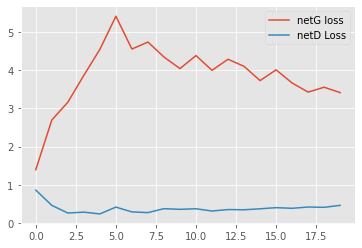

In [7]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('images/ACgan/generator_images.gif', imgs)

# plot and save the netG and netD loss
plt.figure()
plt.plot(losses_g, label='netG loss')
plt.plot(losses_d, label='netD Loss')
plt.legend()
plt.savefig('images/ACgan/losses.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


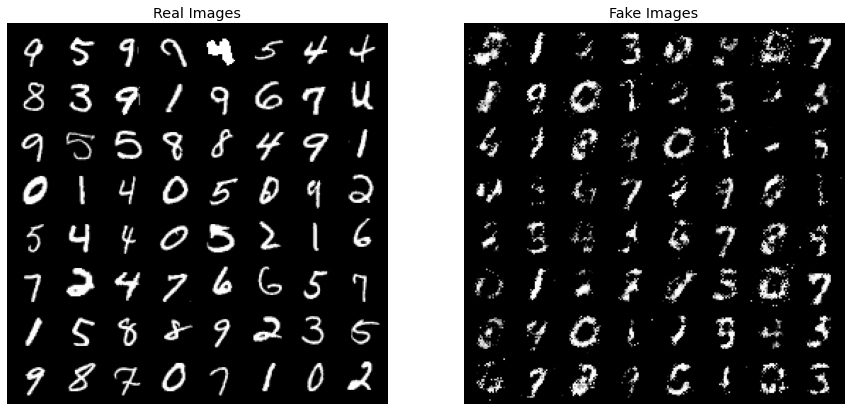

In [8]:
## real vs fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(images[-1],(1,2,0)))
plt.show()

# save the generated images
fig.savefig('images/ACgan/gan_real_vs_fake_images.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

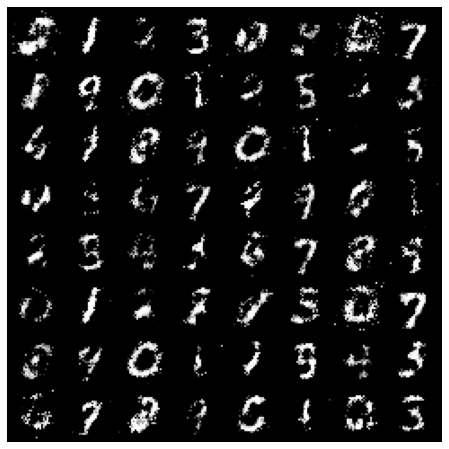

In [9]:
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())